In [11]:
%pip install mplfinance


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import mplfinance as mpf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from model import NaiveBayes, LogisticRegression

In [33]:
# replace formatting so pandas can handle input
with open('rp.data', 'r') as in_file:
    with open('rp_formatted.data', 'w') as out_file:
        for line in in_file:
            out_file.write(re.sub('\s+', '\t', line)[1:] + '\n')

In [31]:
df = pd.read_csv('rp_formatted.data', index_col=False, sep='\t', names=[f'x{i}' for i in range(1,10)] + ['y'])
df = df.drop(['y'], axis=1).sub(1).join(df['y'].map({2: 0, 4: 1}))

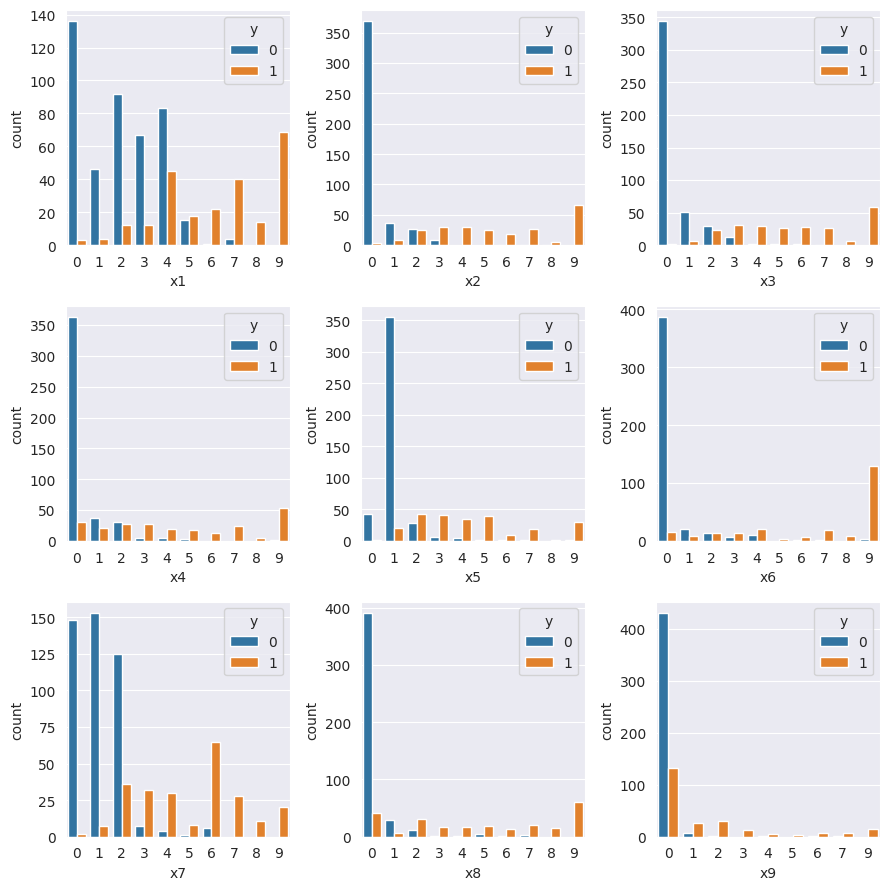

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for i in range(1,10):
    column = f'x{i}'
    sns.countplot(x=df[column], ax=axes[i-1], hue=df['y'])
plt.tight_layout()

In [34]:
def partition(df, frac, seed=1234):
    assert 0 < frac <= 1
    df_0 = df[df['y'] == 0].sample(frac=frac, random_state=seed)
    df_1 = df[df['y'] == 1].sample(frac=frac, random_state=seed)
    df_train = pd.concat([df_0, df_1])
    df_test = df.drop(df_train.index)
    return df_train, df_test


df, _ = partition(df, 1.0, seed=12)
# seed=0
df_train, df_test = partition(df, 2 / 3)
# seed+=1
print("train: ", df_train.shape)
print("test: ", df_test.shape)

train:  (455, 10)
test:  (228, 10)


In [36]:
def get_data(df):
    y = df['y'].to_numpy()
    y = y.reshape([y.shape[0], 1])

    X = df.drop('y', axis=1)
    X.insert(0, 'x0', [1] * df.shape[0])
    X = X.to_numpy()

    return X, y


train_X, train_y = get_data(df_train)
test_X, test_y = get_data(df_test)
print("train: ", train_X.shape)
print("test: ", test_X.shape)

train:  (455, 10)
test:  (228, 10)


In [65]:
def f_score(y_true, y_pred, beta=1.0):
    tp, fp, fn = 0,0,0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i] == 1:
            tp += 1
        elif y_pred[i] == 1 and y_true[i] == 0:
            fp += 1
        elif y_pred[i] == 0 and y_true[i] == 1:
            fn += 1

    if tp == 0:
        return -1
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    return (1 + beta ** 2) * (precision * recall) / (beta ** 2 * precision + recall)

In [38]:
def plot_learning_curve(ax, df, y, label):
    grouped_df = df.dropna(subset=[y]).groupby('frac')[y].mean().reset_index()
    print(grouped_df)
    sns.lineplot(data=grouped_df, ax=ax, x='frac', y=y)

# Naive Bayes

In [39]:
nb_model = NaiveBayes(train_X, train_y, 10, 2)
nb_model.train()
pred_y = nb_model.predict(test_X)
pred_y

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [40]:
res = 0
for i in range(len(pred_y)):
    if pred_y[i] == test_y[i]:
        res += 1
    else:
        print(test_X[i, :], test_y[i], pred_y[i])
print(f'{res}/{len(test_y)} ~= {round(res / len(test_y), 2)}')
print(f'F-score = {f_score(test_y, pred_y, 0.1)}')

[1 7 3 5 2 2 0 3 2 0] [0] 1
[1 2 0 0 2 7 0 4 7 0] [0] 1
[1 1 0 0 0 1 0 0 0 4] [0] 1
[1 5 7 7 0 2 3 2 6 0] [0] 1
[1 4 3 4 0 7 0 2 5 0] [0] 1
[1 4 0 1 9 3 4 1 0 0] [0] 1
[1 4 6 6 0 4 7 2 3 0] [0] 1
[1 5 2 2 4 2 9 2 4 2] [0] 1
[1 0 0 0 1 0 2 0 0 6] [0] 1
[1 1 2 3 3 1 4 1 4 0] [1] 0
218/228 ~= 0.96
F-score = 0.8985360360360359


    frac    fscore
0  0.125  0.909150
1  0.250  0.913847
2  0.625  0.919923
3  1.000  0.921826
    frac       acc
0  0.125  0.770000
1  0.250  0.881930
2  0.625  0.950629
3  1.000  0.962544


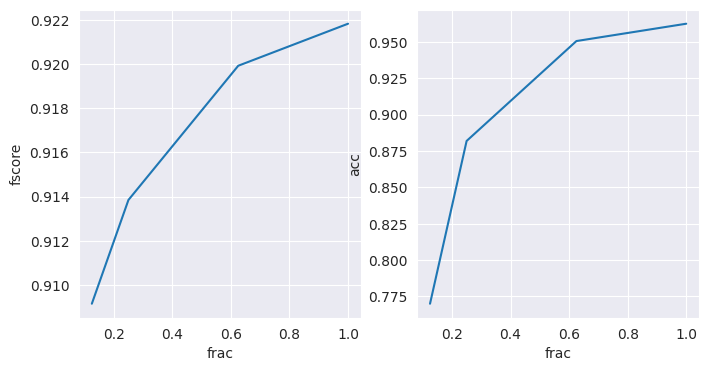

In [54]:
learn_df = pd.read_csv('results/naive_bayes.txt', index_col=False, sep='\t', names=['frac', 'tp', 'size', 'fscore'])
learn_df['acc'] = learn_df['tp']/learn_df['size']

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.flatten()
plot_learning_curve(axes[0], learn_df, 'fscore', "F-score")
plot_learning_curve(axes[1], learn_df, 'acc', "Accuracy")

# Naive Bayes - Laplace Regularization

In [42]:
nbl_model = NaiveBayes(train_X, train_y, 10, 2)
nbl_model.train()
pred_y = nb_model.predict(test_X)
pred_y

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [43]:
res = 0
for i in range(len(pred_y)):
    if pred_y[i] == test_y[i]:
        res += 1
    else:
        print(test_X[i, :], test_y[i], pred_y[i])
acc = round(res / len(test_y), 2)
print(f'{res}/{len(test_y)} ~= {acc}')
print(f'F-score = {f_score(test_y, pred_y, 0.1)}')


[1 7 3 5 2 2 0 3 2 0] [0] 1
[1 2 0 0 2 7 0 4 7 0] [0] 1
[1 1 0 0 0 1 0 0 0 4] [0] 1
[1 5 7 7 0 2 3 2 6 0] [0] 1
[1 4 3 4 0 7 0 2 5 0] [0] 1
[1 4 0 1 9 3 4 1 0 0] [0] 1
[1 4 6 6 0 4 7 2 3 0] [0] 1
[1 5 2 2 4 2 9 2 4 2] [0] 1
[1 0 0 0 1 0 2 0 0 6] [0] 1
[1 1 2 3 3 1 4 1 4 0] [1] 0
218/228 ~= 0.96
F-score = 0.8985360360360359


F-score = 0.8985360360360359
    frac    fscore
0  0.010  0.953358
1  0.020  0.953054
2  0.125  0.943895
3  0.250  0.949769
4  0.625  0.950446
5  1.000  0.946487
    frac       acc
0  0.010  0.930000
1  0.020  0.960000
2  0.125  0.969310
3  0.250  0.975439
4  0.625  0.976713
5  1.000  0.975263


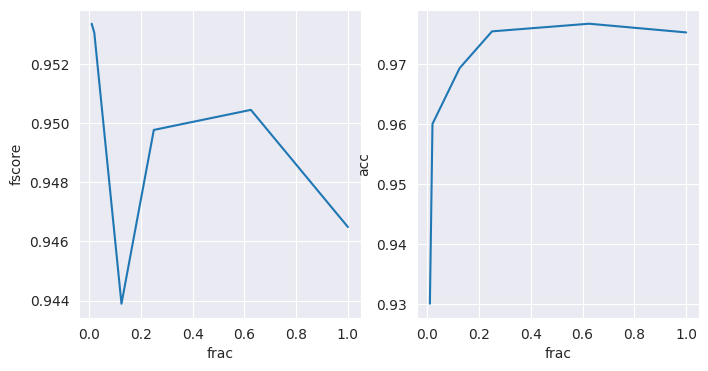

In [55]:
print(f'F-score = {f_score(test_y, pred_y, 0.1)}')
learn_df = pd.read_csv('results/laplace.txt', index_col=False, sep='\t', names=['frac', 'tp', 'size', 'fscore'])
learn_df['acc'] = learn_df['tp']/learn_df['size']

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.flatten()
plot_learning_curve(axes[0], learn_df, 'fscore', "F-score")
plot_learning_curve(axes[1], learn_df, 'acc', "Accuracy")

# Linear Regression

In [26]:
lreg_model = LogisticRegression(train_X, train_y)
thetas, loss = lreg_model.train(10000, 0.001)
print(loss)
%time

0.04835164835164835
CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.11 µs


In [27]:
pred_y = np.where(lreg_model.pred(test_X, thetas[-1]) < 0.5, 0, 1)
res = 0
for i in range(len(pred_y)):
    if pred_y[i] == test_y[i]:
        res += 1
    else:
        print(test_X[i, :], test_y[i], pred_y[i])
acc = round(res / len(test_y), 2)
print(f'{res}/{len(test_y)} ~= {acc}')
# print(f'F-score = {f_score(test_y, pred_y, 0.1)}')

[1 5 7 7 0 2 3 2 6 0] [0] [1]
[1 4 6 6 0 4 7 2 3 0] [0] [1]
[1 5 2 2 4 2 9 2 4 2] [0] [1]
[1 0 0 0 1 0 2 0 0 6] [0] [1]
[1 7 1 2 0 5 2 6 0 0] [1] [0]
[1 7 5 3 9 9 0 2 4 0] [1] [0]
[1 4 1 2 0 5 9 4 0 0] [1] [0]
[1 6 1 3 0 2 3 2 2 0] [1] [0]
220/228 ~= 0.96


In [84]:
def plot(model, thetas, X, y, label=''):
    step = 100
    epochs = [ep for ep in range(0, len(thetas), step)] + [len(thetas)-1]
    # loses = [model.loss(y, model.pred(X, theta)) for theta in thetas[::step]] + [model.loss(y, model.pred(X, thetas[-1]))]
    fscores = [f_score(y, np.where(model.predict(X, theta) < 0.5, 0, 1) , 0.1) for theta in thetas[::step]] + [f_score(y, np.where(model.predict(X, thetas[-1]) < 0.5, 0, 1), 0.1)]
    data = {'epoch': epochs[2:], 'fscore': fscores[2:]}
    sns.lineplot(data=pd.DataFrame(data), x='epoch', y='fscore', label=f'{label}: {np.round(fscores[2:][-1],2)}')

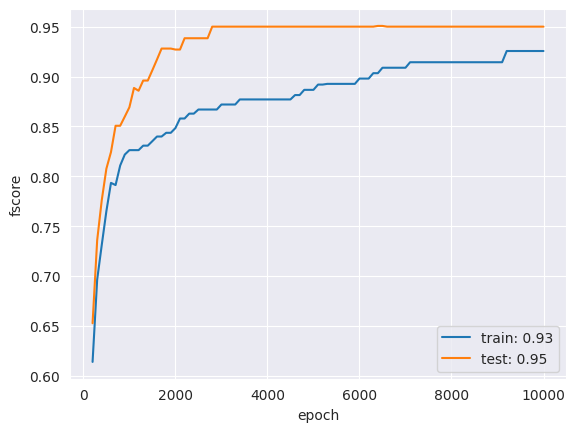

In [85]:
plot(lreg_model, thetas, train_X, train_y, label='train')
plot(lreg_model, thetas, test_X, test_y, label='test')

F-score = 0.8985360360360359
    frac    fscore
0  0.010  0.957111
1  0.020  0.901325
2  0.125  0.902888
3  0.250  0.912095
4  0.625  0.915711
5  1.000  0.916650
    frac       acc
0  0.010  0.745000
1  0.020  0.846000
2  0.125  0.927931
3  0.250  0.937895
4  0.625  0.946364
5  1.000  0.947895


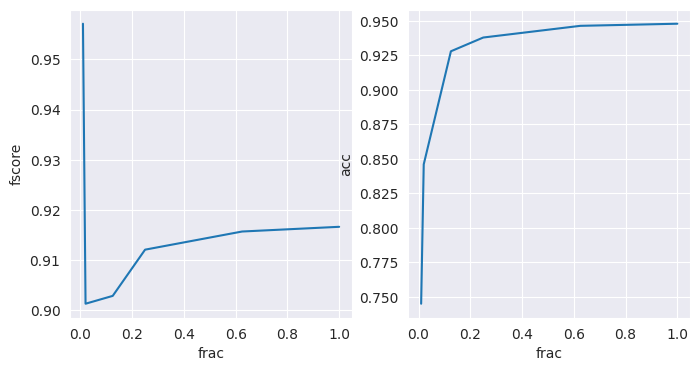

In [53]:
print(f'F-score = {f_score(test_y, pred_y, 0.1)}')
learn_df = pd.read_csv('results/logistic2.txt', index_col=False, sep='\t', names=['frac', 'tp', 'size', 'fscore'])
learn_df['acc'] = learn_df['tp']/learn_df['size']
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.flatten()
plot_learning_curve(axes[0], learn_df, 'fscore', "F-score")
plot_learning_curve(axes[1], learn_df, 'acc', "Accuracy")